## Surviving the Titanic and Random Forest Classifiers

In [47]:
%matplotlib inline

In [48]:
from sklearn.ensemble import RandomForestRegressor

# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score
import pandas as pd

# Importing the data
X = pd.read_csv("train.csv")
y = X.pop("Survived")

In [49]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Filling the missing values of Age with mean of the age.

In [50]:
X["Age"].fillna(X.Age.mean(), inplace=True)

In [51]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [52]:
X.columns

Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'], dtype='object')

Dropping "Name", "PassengerId" and "Parch"  variables. 

In [53]:
X.drop(["Name", "PassengerId", "Parch"], axis=1, inplace=True)

In [54]:
def describe_categorical(X):
   
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [55]:
describe_categorical(X)

,Sex,Ticket,Cabin,Embarked
count,891,891,204,889
unique,2,681,147,3
top,male,CA. 2343,C23 C25 C27,S
freq,577,7,4,644


In [56]:
# Changing the Cabin variable.
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"

X["Cabin"] = X.Cabin.apply(clean_cabin)

Here, Adding 'Fare' and 'Pclass' as categorical variable.

In [57]:
categorical_variables = ['Sex', 'Cabin', 'Embarked', 'Ticket', 'Fare', 'Pclass']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [58]:
# Make train and test datasets
from sklearn.cross_validation import train_test_split
import numpy as np
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

##Model Creation
Here we have the test and train set defined. Using train to train my model and test for the model Accuracy.
#### Building our first model with default values for the parameter.

In [59]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
model.fit(X_train, y_train)
#print "R^2:", model.score(X_test, y_test)
roc = roc_auc_score(y_test, model.predict(X_test))
print "C-stat: ", roc

C-stat:  0.880833333333


### n_jobs

In [60]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X_train, y_train)

1 loops, best of 3: 30.4 s per loop


In [61]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

1 loops, best of 3: 16.3 s per loop


Set n_jobs=-1 Since this model takes lesser time per loop than n_job=1.

### n_estimators

30 trees
C-stat:  0.875833333333

50 trees
C-stat:  0.874743589744

100 trees
C-stat:  0.880833333333

200 trees
C-stat:  0.880833333333

500 trees
C-stat:  0.876282051282

1000 trees
C-stat:  0.873141025641

2000 trees
C-stat:  0.876282051282



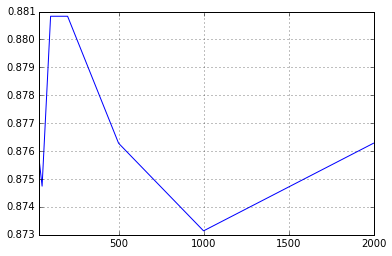

In [63]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    print trees, "trees"
    roc = roc_auc_score(y_test, model.predict(X_test))
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, n_estimator_options).plot();

Choose n_estimater=100.

### max_features

auto option
C-stat:  0.880833333333

None option
C-stat:  0.880833333333

sqrt option
C-stat:  0.872179487179

log2 option
C-stat:  0.874487179487

0.9 option
C-stat:  0.879935897436

0.2 option
C-stat:  0.882756410256



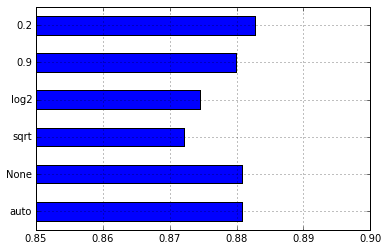

In [64]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X_train, y_train)
    print max_features, "option"
    roc = roc_auc_score(y_test, model.predict(X_test))
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.90));

It is better to choose max_features="auto" as the C-stat is high.

### min_samples_leaf

1 min samples
C-stat:  0.880833333333

2 min samples
C-stat:  0.873076923077

3 min samples
C-stat:  0.882307692308

4 min samples
C-stat:  0.885064102564

5 min samples
C-stat:  0.878846153846

6 min samples
C-stat:  0.872115384615

7 min samples
C-stat:  0.868782051282

8 min samples
C-stat:  0.867371794872

9 min samples
C-stat:  0.8625

10 min samples
C-stat:  0.862307692308



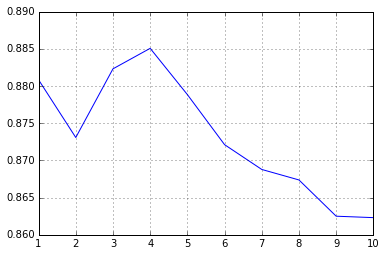

In [65]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=100, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print min_samples, "min samples"
    roc = roc_auc_score(y_test, model.predict(X_test))
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

Here C-stat is high when min_samples_leaf=4.

## Final model

In [66]:
#Construct a model
model = RandomForestRegressor(n_estimators=100, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=4)
model.fit(X_train, y_train)
roc = roc_auc_score(y_test, model.predict(X_test))
print "C-stat: ", roc

C-stat:  0.885064102564


In [67]:
model.oob_score_

0.43503685253488822

In [68]:
model.feature_importances_

array([  2.06547303e-01,   5.50351120e-02,   2.25512496e-01,
         2.09246584e-01,   1.87959416e-03,   2.74566373e-03,
         1.09495183e-02,   2.05569365e-03,   9.72340722e-03,
         1.01874494e-03,   0.00000000e+00,   5.00589064e-02,
         0.00000000e+00,   1.00572257e-02,   0.00000000e+00,
         5.79093539e-03,   2.08922313e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

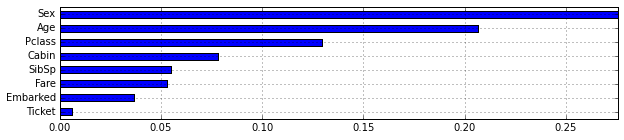

In [69]:
#Bar chart that shows importance of the variables
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)